In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pickle

In [2]:
import torch
%env CUDA_VISIBLE_DEVICES=0
torch.cuda.is_available()

env: CUDA_VISIBLE_DEVICES=0


False

In [3]:
import scvi

/home/boiarskr/GitLab/cancer-sc-embed/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/boiarskr/GitLab/cancer-sc-embed/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create anndata object for SyS data

In [4]:
counts = pd.read_table("data/infercnv_input_files/sys/counts.txt", index_col=0)

In [5]:
cell_annots = pd.read_csv("gs://rebecca-summer23/sys_jerby_data/GSM3770931_SyS.tumors_cell.annotations.csv")

In [6]:
# limit counts to the cells that are in cell_annots
assert(np.all(cell_annots.title.isin(counts.columns)))

counts = counts.loc[:,cell_annots.title]

In [7]:
sys_adata = sc.AnnData(counts.T, obs=cell_annots.drop(columns=["Sample name","processed data file","raw file","molecule","source name","organism"]).set_index("title").rename_axis(None, axis=0))

In [8]:
sys_adata

AnnData object with n_obs × n_vars = 6951 × 23686
    obs: 'characteristics: sample', 'characteristics: cell.type', 'characteristics: tag', 'description'

In [9]:
sys_adata.obs.rename(columns={"characteristics: sample":"sample","characteristics: cell.type":"celltype", "characteristics: tag":"tag"}, inplace=True)

In [10]:
sys_adata.obs.celltype.value_counts()

celltype
Malignant      4371
Macrophage      943
T.CD8           659
T.CD4           235
T.cell          206
Mastocyte       185
NK              102
B.cell           90
Fibroblast       81
Endothelial      79
Name: count, dtype: int64

In [11]:
sc.pp.filter_cells(sys_adata, min_genes=200)
sc.pp.filter_genes(sys_adata, min_cells=3)

In [12]:
sys_adata

AnnData object with n_obs × n_vars = 6951 × 21759
    obs: 'sample', 'celltype', 'tag', 'description', 'n_genes'
    var: 'n_cells'

In [13]:
sys_adata.layers['counts'] = sys_adata.X.copy()

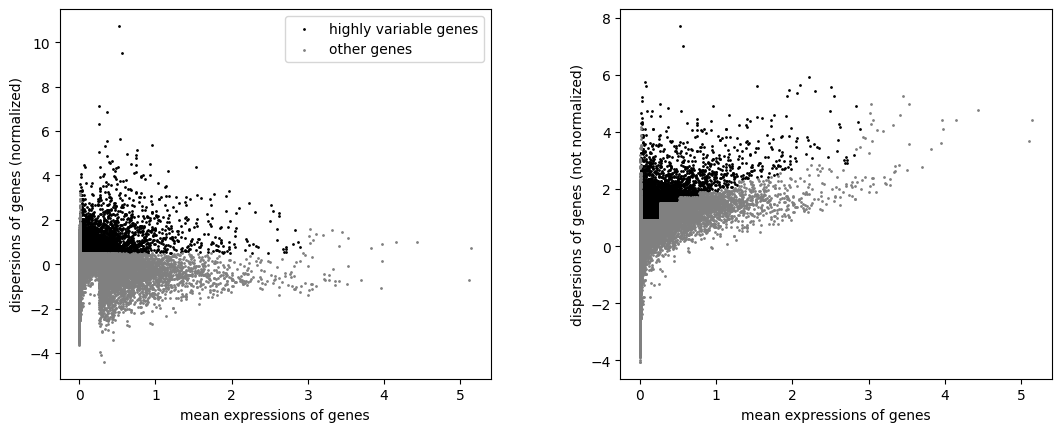

In [14]:
sc.pp.normalize_total(sys_adata, target_sum=1e4)
sc.pp.log1p(sys_adata)
sc.pp.highly_variable_genes(sys_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(sys_adata)

## Filter to tumor cells + HVGs

In [15]:
sys_adata_hvg = sys_adata[sys_adata.obs.celltype=="Malignant",sys_adata.var.highly_variable].copy()

In [16]:
sys_adata_hvg.layers['counts'].shape

(4371, 5912)

# run basic scVI

In [29]:
scvi.model.SCVI.setup_anndata(sys_adata_hvg, layer="counts")

In [30]:
vae = scvi.model.SCVI(sys_adata_hvg, gene_likelihood='nb')

In [31]:
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [01:52<00:00,  3.53it/s, v_num=1, train_loss_step=6.63e+3, train_loss_epoch=6.55e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:52<00:00,  3.55it/s, v_num=1, train_loss_step=6.63e+3, train_loss_epoch=6.55e+3]


In [33]:
sys_adata_hvg.obsm["X_scvi"] = vae.get_latent_representation()

In [56]:
#post-code changes -- not qualitatively different (which is good, since I did not pass in CNVs in this test)
sc.pp.neighbors(sys_adata_hvg, use_rep="X_scvi")
sc.tl.umap(sys_adata_hvg)

/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


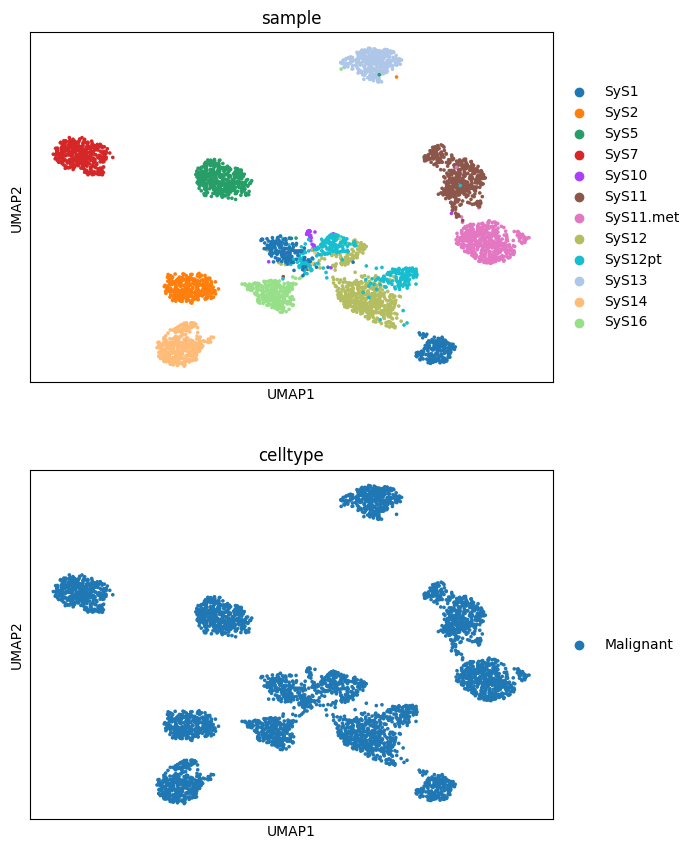

In [57]:
sc.pl.umap(sys_adata_hvg, color=["sample", "celltype"], ncols=1)

## Create perturbed object, where half the cells have a fold change of {4} in half the genes

#### perturbing full cells doesnt work since it just changes library size but not gene rates - cells from the same patient are still most similar to each other - need to perturb half the genes

#### perturbing half the genes in half the cells

In [18]:
sys_adata_hvg.layers['perturbed_counts'] = sys_adata_hvg.layers['counts'].copy()

In [19]:
perturb_idx_cell = np.random.choice(np.arange(len(sys_adata_hvg)), size=round(len(sys_adata_hvg)/2), replace=False)

In [20]:
perturb_mask = np.ones_like(sys_adata_hvg.layers['perturbed_counts'])

In [21]:
perturb_mask[perturb_idx_cell,:round(perturb_mask.shape[1]/2)] = 4

In [22]:
sys_adata_hvg.layers['perturbed_counts'] = sys_adata_hvg.layers['perturbed_counts'] * perturb_mask

In [23]:
# add a col in obs denoting whether a cell was perturbed
sys_adata_hvg.obs['perturbed'] = np.zeros(len(sys_adata_hvg.obs))
sys_adata_hvg.obs.perturbed.iloc[perturb_idx_cell]=1

/tmp/ipykernel_27792/860573588.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sys_adata_hvg.obs.perturbed.iloc[perturb_idx_cell]=1


In [110]:
scvi.model.SCVI.setup_anndata(sys_adata_hvg, layer="perturbed_counts")

In [111]:
vae = scvi.model.SCVI(sys_adata_hvg, gene_likelihood='nb')

In [112]:
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [01:53<00:00,  3.54it/s, v_num=1, train_loss_step=7.11e+3, train_loss_epoch=6.96e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:53<00:00,  3.51it/s, v_num=1, train_loss_step=7.11e+3, train_loss_epoch=6.96e+3]


In [113]:
sys_adata_hvg.obsm["X_scvi_perturbed"] = vae.get_latent_representation()

In [114]:
#post-code changes -- not qualitatively different (which is good, since I did not pass in CNVs in this test)
sc.pp.neighbors(sys_adata_hvg, use_rep="X_scvi_perturbed")
sc.tl.umap(sys_adata_hvg)

/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


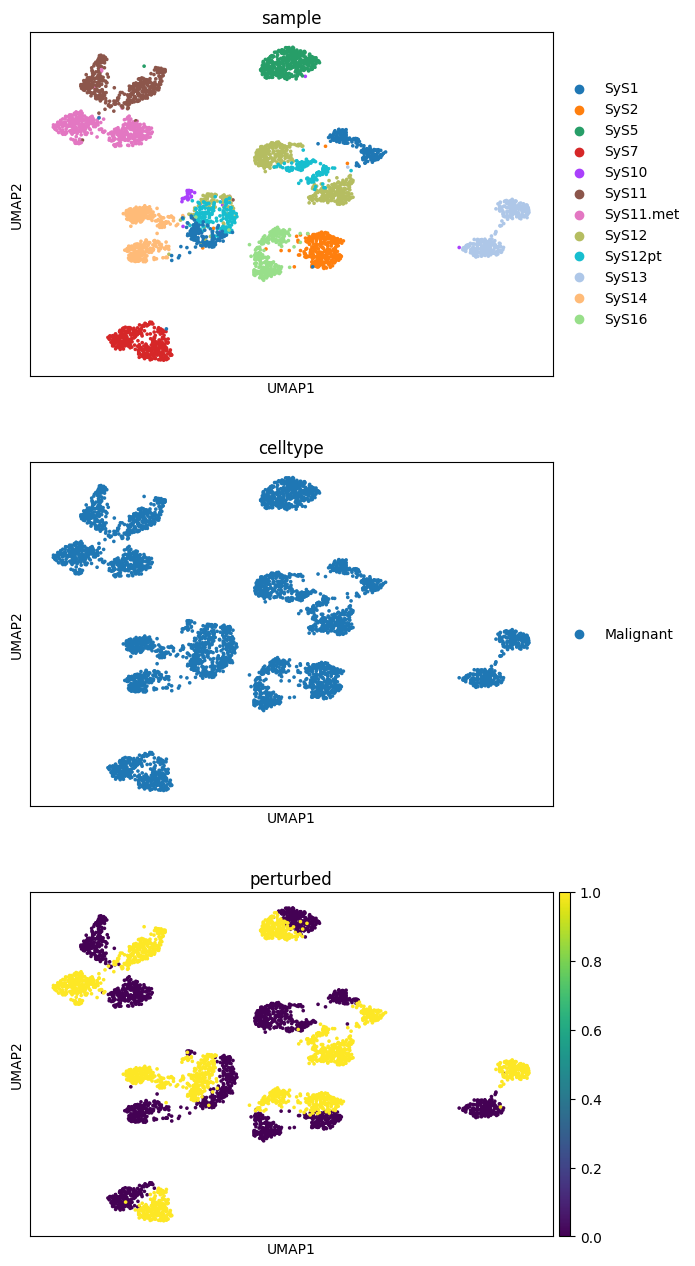

In [115]:
sc.pl.umap(sys_adata_hvg, color=["sample", "celltype","perturbed"], ncols=1)

# now "correct" for perturb_mask using cnv code

In [24]:
sys_adata_hvg.obsm['cnv'] = perturb_mask

In [25]:
scvi.model.SCVI.setup_anndata(sys_adata_hvg, layer="perturbed_counts", cnv_key="cnv")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     Generating sequential column names                                                                        


In [26]:
vae = scvi.model.SCVI(sys_adata_hvg, gene_likelihood='nb')

In [27]:
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [03:20<00:00,  2.00it/s, v_num=1, train_loss_step=7.15e+3, train_loss_epoch=6.95e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:20<00:00,  1.99it/s, v_num=1, train_loss_step=7.15e+3, train_loss_epoch=6.95e+3]


In [28]:
sys_adata_hvg.obsm["X_scvi_perturbed_cnvcorrect"] = vae.get_latent_representation()

In [29]:
#post-code changes -- not qualitatively different (which is good, since I did not pass in CNVs in this test)
sc.pp.neighbors(sys_adata_hvg, use_rep="X_scvi_perturbed_cnvcorrect")
sc.tl.umap(sys_adata_hvg)

/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/umap/dist

/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


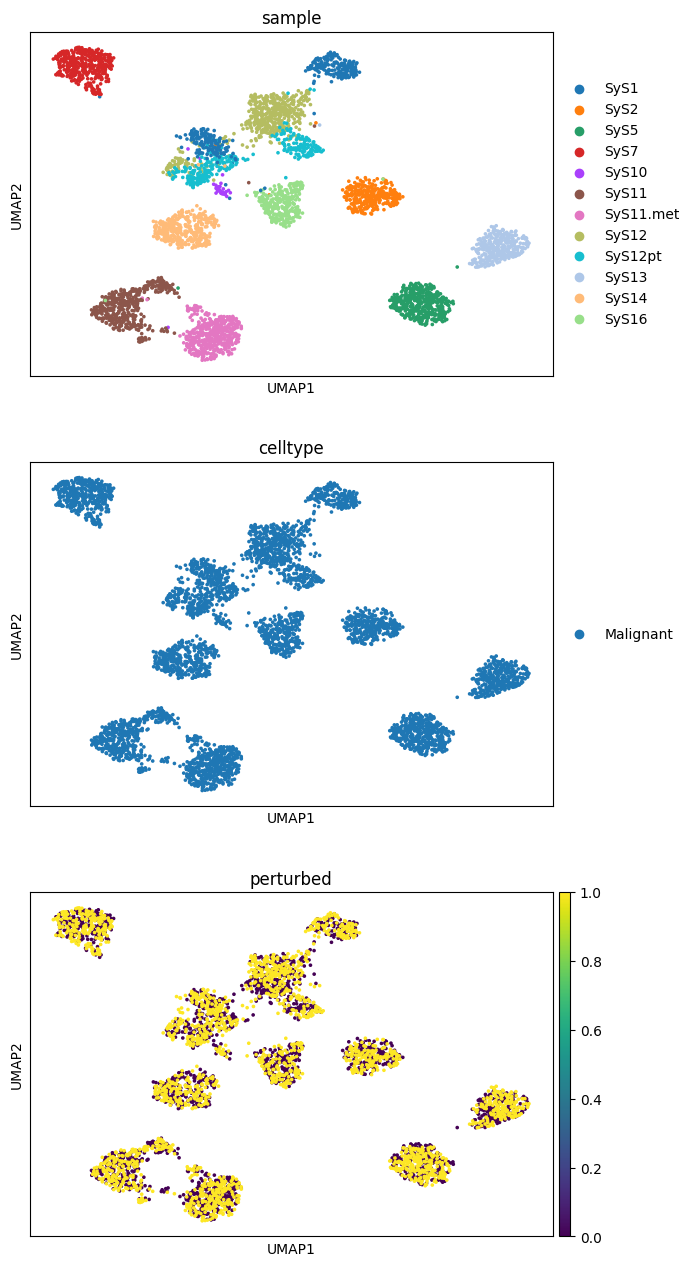

In [30]:
sc.pl.umap(sys_adata_hvg, color=["sample", "celltype","perturbed"], ncols=1)

## Create perturbed object, where half the cells have a fold change of {1.5} in half the genes

In [25]:
fc_mag = 1.5

#### perturbing half the genes in half the cells

In [26]:
sys_adata_hvg.layers['perturbed_counts'] = sys_adata_hvg.layers['counts'].copy()

In [27]:
perturb_idx_cell = np.random.choice(np.arange(len(sys_adata_hvg)), size=round(len(sys_adata_hvg)/2), replace=False)

In [28]:
perturb_mask = np.ones_like(sys_adata_hvg.layers['perturbed_counts'])

In [29]:
perturb_mask[perturb_idx_cell,:round(perturb_mask.shape[1]/2)] = fc_mag

In [30]:
sys_adata_hvg.layers['perturbed_counts'] = sys_adata_hvg.layers['perturbed_counts'] * perturb_mask

In [31]:
# add a col in obs denoting whether a cell was perturbed
sys_adata_hvg.obs['perturbed'] = np.zeros(len(sys_adata_hvg.obs))
sys_adata_hvg.obs.perturbed.iloc[perturb_idx_cell]=1

/tmp/ipykernel_2325/860573588.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sys_adata_hvg.obs.perturbed.iloc[perturb_idx_cell]=1


In [32]:
scvi.model.SCVI.setup_anndata(sys_adata_hvg, layer="perturbed_counts")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [33]:
vae = scvi.model.SCVI(sys_adata_hvg, gene_likelihood='nb')

In [34]:
vae.train()

/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [05:44<00:00,  1.16it/s, v_num=1, train_loss_step=6.7e+3, train_loss_epoch=6.55e+3] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [05:44<00:00,  1.16it/s, v_num=1, train_loss_step=6.7e+3, train_loss_epoch=6.55e+3]


In [35]:
sys_adata_hvg.obsm["X_scvi_perturbed"] = vae.get_latent_representation()

In [36]:
#post-code changes -- not qualitatively different (which is good, since I did not pass in CNVs in this test)
sc.pp.neighbors(sys_adata_hvg, use_rep="X_scvi_perturbed")
sc.tl.umap(sys_adata_hvg)

/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/umap/dist

/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


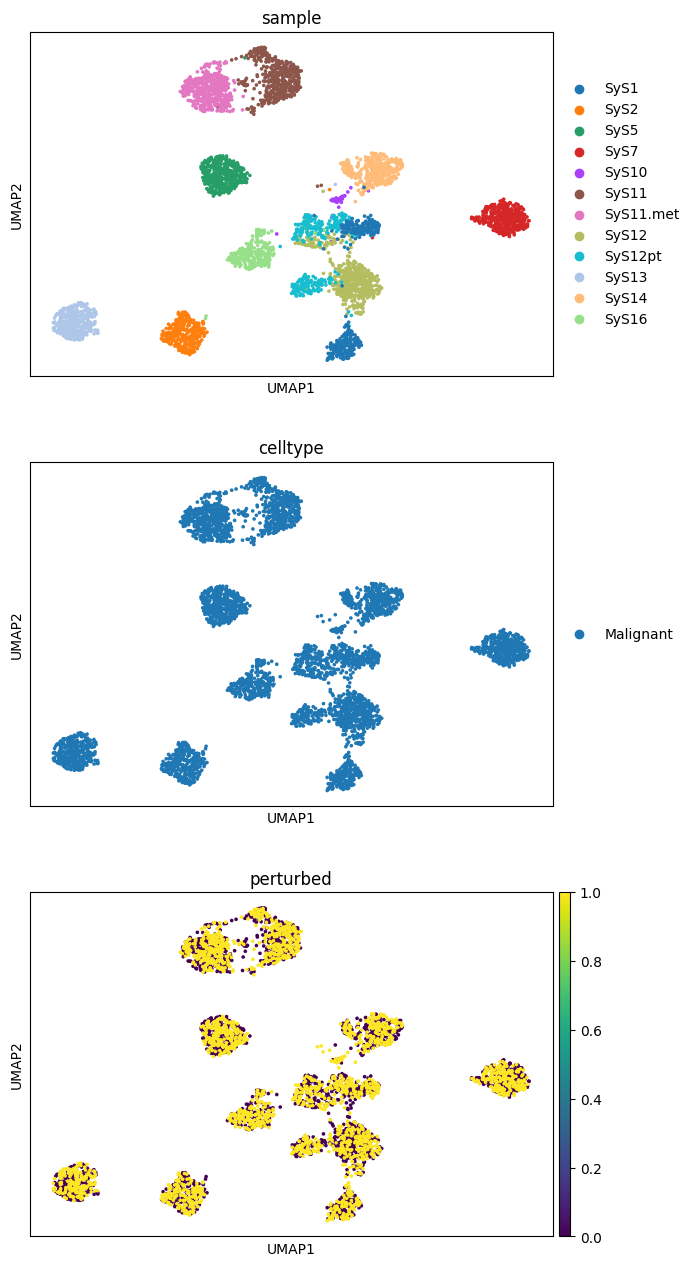

In [37]:
sc.pl.umap(sys_adata_hvg, color=["sample", "celltype","perturbed"], ncols=1)

## Create perturbed object, where half the cells have a fold change of {1.5} in 3/4 of the genes

In [45]:
4389/5912 #actual frac of genes that have CNV in at least one cell

0.7423883626522327

In [46]:
fc_mag = 1.5

In [47]:
sys_adata_hvg.layers['perturbed_counts'] = sys_adata_hvg.layers['counts'].copy()

In [48]:
perturb_idx_cell = np.random.choice(np.arange(len(sys_adata_hvg)), size=round(len(sys_adata_hvg)/2), replace=False)

In [49]:
perturb_mask = np.ones_like(sys_adata_hvg.layers['perturbed_counts'])

In [50]:
perturb_mask[perturb_idx_cell,:round(perturb_mask.shape[1]*3/4)] = fc_mag

In [51]:
sys_adata_hvg.layers['perturbed_counts'] = sys_adata_hvg.layers['perturbed_counts'] * perturb_mask

In [52]:
# add a col in obs denoting whether a cell was perturbed
sys_adata_hvg.obs['perturbed'] = np.zeros(len(sys_adata_hvg.obs))
sys_adata_hvg.obs.perturbed.iloc[perturb_idx_cell]=1

/tmp/ipykernel_2325/860573588.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sys_adata_hvg.obs.perturbed.iloc[perturb_idx_cell]=1


In [53]:
scvi.model.SCVI.setup_anndata(sys_adata_hvg, layer="perturbed_counts")

In [54]:
vae = scvi.model.SCVI(sys_adata_hvg, gene_likelihood='nb')

In [55]:
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [06:06<00:00,  1.13it/s, v_num=1, train_loss_step=6.57e+3, train_loss_epoch=6.53e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [06:06<00:00,  1.09it/s, v_num=1, train_loss_step=6.57e+3, train_loss_epoch=6.53e+3]


In [56]:
sys_adata_hvg.obsm["X_scvi_perturbed"] = vae.get_latent_representation()

In [57]:
#post-code changes -- not qualitatively different (which is good, since I did not pass in CNVs in this test)
sc.pp.neighbors(sys_adata_hvg, use_rep="X_scvi_perturbed")
sc.tl.umap(sys_adata_hvg)

/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


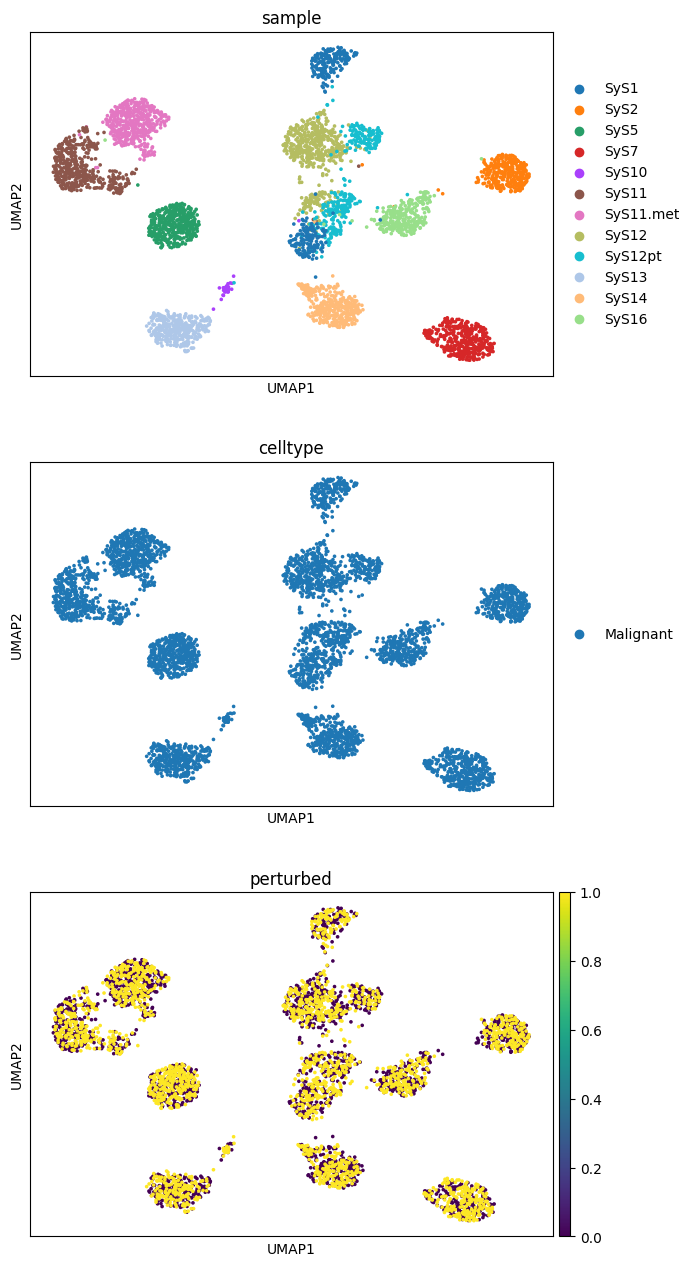

In [58]:
sc.pl.umap(sys_adata_hvg, color=["sample", "celltype","perturbed"], ncols=1)